In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy, os, glob, sys, re
import matplotlib.ticker as mtick

In [3]:
sys.path.append('/'.join(os.path.realpath('..').split('/')[:4]) + '/Python')
import FigureTools

In [6]:
base_dir = os.path.realpath('../..')
print(base_dir)

/Users/jeroen/Dropbox (Brown)/Postdoc FHL/JEROEN/SOC_STRUCT_LEARN/Code_share/NHB_motives_structure/Study1_MTurk


In [9]:
gameDat = pd.read_csv(base_dir + '/Data/Cleaned/gameDat.csv',
                      index_col = 0, dtype={ 'subID':str})
gameDat.head()

,sub,subID,Block,Player,Type,Variant,Type_Total,Trial,S,T,GameType,Colors,CorrAns,GivenAns,ConfidenceNum,ScoreNum,RT_radio,RT_submit,SelfReport
0,3,2003,0,G.P.,opt,nat,opt_nat,0,3,12,PD,"['Blue', 'Red']",def,def,70,1,10439,14310,maximize own score
1,3,2003,0,G.P.,opt,nat,opt_nat,1,7,8,HG,"['Blue', 'Red']",coop,coop,80,1,5259,8262,maximize own score
2,3,2003,0,G.P.,opt,nat,opt_nat,2,3,8,SH,"['Blue', 'Red']",coop,coop,80,1,2764,5519,maximize own score
3,3,2003,0,G.P.,opt,nat,opt_nat,3,7,12,SG,"['Blue', 'Red']",def,def,80,1,4497,7794,maximize own score
4,3,2003,0,G.P.,opt,nat,opt_nat,4,0,15,PD,"['Blue', 'Red']",def,def,70,1,12523,16207,maximize own score


In [10]:
gameDat['AnsNum'] = gameDat['GivenAns'].apply(lambda x: int(x == 'coop'))
gameDat['phase'] = gameDat['Trial'].apply(lambda x: 'early' if x < 8 else 'late')
gameDat['Trial_total'] = gameDat['Block']*16 + gameDat['Trial']

In [11]:
blockDat = gameDat[['subID','Type_Total','Type','Variant','ConfidenceNum','ScoreNum']
                  ].groupby(['subID','Type_Total','Type','Variant'], as_index=False).mean()
blockDat = blockDat.rename(columns={'ConfidenceNum':'Confidence','ScoreNum':'Score'})
subIDs = blockDat['subID'].unique()
print(len(subIDs))
blockDat.head()

150


,subID,Type_Total,Type,Variant,Confidence,Score
0,2003,opt_inv,opt,inv,50.625,0.4375
1,2003,opt_nat,opt,nat,89.375,1.0000
2,2003,pess_inv,pess,inv,50.000,0.5000
3,2003,pess_nat,pess,nat,52.500,0.5625
4,2004,opt_inv,opt,inv,53.125,0.2500


## Load model fits

In [14]:
def load_model_fits(date_string, features,
                    niter = 10, gaze = False, model_string = 'FeatureRL', fit_to = 'joint'):
    
    print(date_string, features)
    
    if model_string == "FeatureRL":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,features,date_string, fit_to, gaze, niter),
               index_col = None, dtype={'sub_ID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
    elif model_string == "BayesianIO":
        model_fits = pd.read_csv(base_dir + 
             '/Data/Modeled/' +
             '%s_%s_fitto-%s_gaze-%s_niter-%i.csv'%(
                 model_string,date_string, fit_to, gaze, niter),
               index_col = 0, dtype={'subID':str, 'comb':str, 'fit_to':str, 'sub_ind':int})
        cost_type = model_fits['costType'].unique()
        if len(cost_type) > 1:
            raise ValueError('Multiple cost types detected - write code to deal with that')
        else:
            model_fits = model_fits.rename(columns = {'costVal':cost_type[0]})
    display(model_fits.head())
    print(model_fits.shape)
    return model_fits

### FeatureRL with motives (groups 1 and 2)

In [15]:
date_string = '2020-03-24'
features = 'CoGrRiNa'
model_fits = load_model_fits(date_string, features)

2020-03-24 CoGrRiNa


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_1,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features
0,1,2003,joint,1,0001,Nash,0,0,0,1.169,...,2.571,NaN,NaN,NaN,SSE,5.333,-11.414,35.305,FeatureRL,CoGrRiNa
1,1,2003,joint,2,0010,Risk,0,0,0,0.169,...,0.415,NaN,NaN,NaN,SSE,6.374,-17.113,46.702,FeatureRL,CoGrRiNa
2,1,2003,joint,3,0011,Risk_Nash,0,0,0,0.544,...,-1.963,5.234,NaN,NaN,SSE,5.641,-13.229,43.093,FeatureRL,CoGrRiNa
3,1,2003,joint,4,0100,Greed,0,0,0,0.855,...,2.636,NaN,NaN,NaN,SSE,3.581,1.077,10.323,FeatureRL,CoGrRiNa
4,1,2003,joint,5,0101,Greed_Nash,0,0,0,0.878,...,3.418,0.481,NaN,NaN,SSE,3.458,2.187,12.261,FeatureRL,CoGrRiNa


(2250, 23)


##### Group 1: Extract full model fits (comb 1111)

In [16]:
group_1 = model_fits.query('comb == "1111"').copy().reset_index(drop=True)
group_1['model_descr'] = 'All Motives'
display(group_1.head())
group_1.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_2,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features,model_descr
0,1,2003,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.158,...,1.104,0.252,-0.230,SSE,3.278,4.281,16.391,FeatureRL,CoGrRiNa,All Motives
1,10,2015,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.333,...,2.173,0.542,0.400,SSE,4.468,-5.637,36.227,FeatureRL,CoGrRiNa,All Motives
2,100,2135,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.194,...,1.645,-0.596,0.007,SSE,0.842,47.760,-70.566,FeatureRL,CoGrRiNa,All Motives
3,101,2136,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.322,...,1.226,-0.566,2.620,SSE,3.374,3.355,18.244,FeatureRL,CoGrRiNa,All Motives
4,102,2137,joint,15,1111,Coop_Greed_Risk_Nash,0,0,0,0.294,...,3.835,0.256,-0.525,SSE,5.825,-14.120,53.193,FeatureRL,CoGrRiNa,All Motives


(150, 24)

##### Group 2: Tag best model per subject

In [18]:
model_fits['best_model'] = False
for sub_ID in model_fits['sub_ID'].unique():
    sub_dat = model_fits.query('sub_ID == @sub_ID').sort_values(by='BIC',ascending=True).copy()
    best_model = sub_dat.iloc[0]
    best_BIC = best_model['BIC']
    model_fits.loc[(model_fits['sub_ID']==sub_ID) & (model_fits['BIC']==best_BIC),'best_model'] = True

In [19]:
group_2 = model_fits.query('best_model == True').copy().reset_index(drop=True)
group_2['model_descr'] = 'Best Motives'
display(group_2.head())
group_2.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features,best_model,model_descr
0,1,2003,joint,12,1100,Coop_Greed,0,0,0,1.867,...,NaN,NaN,SSE,3.055,6.530,3.576,FeatureRL,CoGrRiNa,True,Best Motives
1,10,2015,joint,4,0100,Greed,0,0,0,0.617,...,NaN,NaN,SSE,4.425,-5.323,23.122,FeatureRL,CoGrRiNa,True,Best Motives
2,100,2135,joint,12,1100,Coop_Greed,0,0,0,0.424,...,NaN,NaN,SSE,0.823,48.511,-80.387,FeatureRL,CoGrRiNa,True,Best Motives
3,101,2136,joint,9,1001,Coop_Nash,0,0,0,1.359,...,NaN,NaN,SSE,3.242,4.629,7.377,FeatureRL,CoGrRiNa,True,Best Motives
4,102,2137,joint,12,1100,Coop_Greed,0,0,0,0.932,...,NaN,NaN,SSE,3.901,-1.289,19.214,FeatureRL,CoGrRiNa,True,Best Motives


(150, 25)

##### Find commonest best model -- use as comparison

In [20]:
group_2b = model_fits.query('comb == "1100"').copy().reset_index(drop=True)
group_2b['model_descr'] = 'Coop-Greed'
display(group_2b.head())
group_2b.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_3,feature_weight_4,cost_type,SSE,LL,BIC,model_type,features,best_model,model_descr
0,1,2003,joint,12,1100,Coop_Greed,0,0,0,1.867,...,NaN,NaN,SSE,3.055,6.530,3.576,FeatureRL,CoGrRiNa,True,Coop-Greed
1,10,2015,joint,12,1100,Coop_Greed,0,0,0,0.528,...,NaN,NaN,SSE,4.354,-4.802,26.239,FeatureRL,CoGrRiNa,False,Coop-Greed
2,100,2135,joint,12,1100,Coop_Greed,0,0,0,0.424,...,NaN,NaN,SSE,0.823,48.511,-80.387,FeatureRL,CoGrRiNa,True,Coop-Greed
3,101,2136,joint,12,1100,Coop_Greed,0,0,0,0.137,...,NaN,NaN,SSE,4.305,-4.446,25.527,FeatureRL,CoGrRiNa,False,Coop-Greed
4,102,2137,joint,12,1100,Coop_Greed,0,0,0,0.932,...,NaN,NaN,SSE,3.901,-1.289,19.214,FeatureRL,CoGrRiNa,True,Coop-Greed


(150, 25)

### Game Types + intercept (group 3)

In [21]:
date_string = '2020-03-24'
features = 'CoHgShSgPd'
model_fits = load_model_fits(date_string, features)

2020-03-24 CoHgShSgPd


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_2,feature_weight_3,feature_weight_4,feature_weight_5,cost_type,SSE,LL,BIC,model_type,features
0,1,2003,joint,1,00001,Prisoners,0,0,0,6.692,...,NaN,NaN,NaN,NaN,SSE,6.032,-15.673,43.823,FeatureRL,CoHgShSgPd
1,1,2003,joint,2,00010,Snowdrift,0,0,0,0.860,...,NaN,NaN,NaN,NaN,SSE,6.027,-15.368,43.213,FeatureRL,CoHgShSgPd
2,1,2003,joint,3,00011,Snowdrift_Prisoners,0,0,0,1.730,...,-1.580,NaN,NaN,NaN,SSE,5.691,-13.931,44.497,FeatureRL,CoHgShSgPd
3,1,2003,joint,4,00100,StagHunt,0,0,0,2.233,...,NaN,NaN,NaN,NaN,SSE,5.124,-10.015,32.506,FeatureRL,CoHgShSgPd
4,1,2003,joint,5,00101,StagHunt_Prisoners,0,0,0,3.233,...,-4.286,NaN,NaN,NaN,SSE,4.779,-7.796,32.227,FeatureRL,CoHgShSgPd


(4650, 24)


In [23]:
group_3 = (model_fits.query('comb == "11111"')
           .copy().reset_index(drop=True))
group_3['model_descr'] = 'Game Types'
display(group_3.head())
group_3.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_3,feature_weight_4,feature_weight_5,cost_type,SSE,LL,BIC,model_type,features,model_descr
0,1,2003,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,4.017,...,7.443,-3.633,-7.033,SSE,3.497,2.214,24.685,FeatureRL,CoHgShSgPd,Game Types
1,2,2004,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,0.503,...,2.470,-1.078,-0.194,SSE,3.738,0.078,28.956,FeatureRL,CoHgShSgPd,Game Types
2,3,2005,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,0.232,...,2.872,-0.776,-2.248,SSE,3.199,5.056,18.999,FeatureRL,CoHgShSgPd,Game Types
3,4,2006,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,2.251,...,3.248,-8.066,-3.198,SSE,1.894,21.834,-14.555,FeatureRL,CoHgShSgPd,Game Types
4,5,2008,joint,31,11111,Coop_Harmony_StagHunt_Snowdrift_Prisoners,0,0,0,0.987,...,1.341,-1.693,-1.866,SSE,6.293,-16.591,62.295,FeatureRL,CoHgShSgPd,Game Types


(150, 25)

### Games + intercept (group 4)

In [24]:
date_string = '2020-03-26'
features = 'CoST'
model_fits = load_model_fits(date_string, features)

2020-03-26 CoST


,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_14,feature_weight_15,feature_weight_16,feature_weight_17,cost_type,SSE,LL,BIC,model_type,features
0,1,2003,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,4.842,15.207,-9.088,-1.959,SSE,3.879,-1.112,81.242,FeatureRL,CoST
1,2,2004,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,15.200,14.886,-6.938,-11.979,SSE,3.007,7.038,64.942,FeatureRL,CoST
2,3,2005,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,0.631,10.107,-3.458,-10.268,SSE,2.437,13.759,51.501,FeatureRL,CoST
3,4,2006,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,3.971,3.967,-8.355,-5.311,SSE,2.037,19.499,40.020,FeatureRL,CoST
4,5,2008,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.54,...,1.889,0.846,-1.636,-2.217,SSE,6.054,-15.356,109.731,FeatureRL,CoST


(150, 36)


In [25]:
group_4 = (model_fits
           .copy().reset_index(drop=True))
group_4['model_descr'] = 'Games'
display(group_4.head())
group_4.shape

,sub_ind,sub_ID,fit_to,comb_index,comb,feature_names,asymm_LR,bounded_weights,gaze,LR_up,...,feature_weight_15,feature_weight_16,feature_weight_17,cost_type,SSE,LL,BIC,model_type,features,model_descr
0,1,2003,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,15.207,-9.088,-1.959,SSE,3.879,-1.112,81.242,FeatureRL,CoST,Games
1,2,2004,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,14.886,-6.938,-11.979,SSE,3.007,7.038,64.942,FeatureRL,CoST,Games
2,3,2005,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,10.107,-3.458,-10.268,SSE,2.437,13.759,51.501,FeatureRL,CoST,Games
3,4,2006,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.01,...,3.967,-8.355,-5.311,SSE,2.037,19.499,40.020,FeatureRL,CoST,Games
4,5,2008,joint,131071,11111111111111111,Coop_S0T5_S0T8_S0T12_S0T15_S3T5_S3T8_S3T12_S3T...,0,0,0,0.54,...,0.846,-1.636,-2.217,SSE,6.054,-15.356,109.731,FeatureRL,CoST,Games


(150, 37)

## Compare

In [59]:
all_model_fits = group_1.append(group_2).append(group_2b).append(group_3).append(group_4)

In [60]:
all_model_fits.columns

Index(['BIC', 'LL', 'LR_down', 'LR_up', 'SSE', 'asymm_LR', 'best_model',
       'bounded_weights', 'comb', 'comb_index', 'cost_type', 'feature_names',
       'feature_weight_1', 'feature_weight_10', 'feature_weight_11',
       'feature_weight_12', 'feature_weight_13', 'feature_weight_14',
       'feature_weight_15', 'feature_weight_16', 'feature_weight_17',
       'feature_weight_2', 'feature_weight_3', 'feature_weight_4',
       'feature_weight_5', 'feature_weight_6', 'feature_weight_7',
       'feature_weight_8', 'feature_weight_9', 'features', 'fit_to', 'gaze',
       'gaze_bias', 'inv_temp', 'model_descr', 'model_type', 'sub_ID',
       'sub_ind'],
      dtype='object')

##### Remove outliers

[-137.90725000000003, 202.45200000000006]


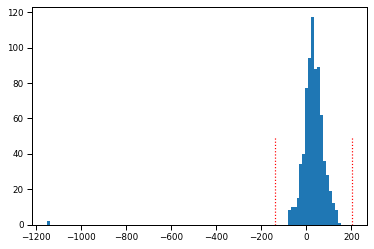

In [61]:
BICs = all_model_fits['BIC'].values
plt.hist(BICs, 100);
iqr = (all_model_fits['BIC'].describe()['75%'] - 
       all_model_fits['BIC'].describe()['25%'])
accepted_range = [all_model_fits['BIC'].describe()['25%'] - 3*iqr,
                  all_model_fits['BIC'].describe()['75%'] + 3*iqr]
min_BIC,max_BIC = accepted_range
print(accepted_range)
plt.plot([min_BIC,min_BIC],[0,50],'r:')
plt.plot([max_BIC,max_BIC],[0,50],'r:')

In [62]:
outlier_subjects = all_model_fits.query(
    '(BIC < @min_BIC | BIC > @max_BIC)')[
    ['sub_ind','sub_ID']].drop_duplicates()
# outlier_sub_inds = outlier_subjects['sub_ind'].unique()
outlier_subjects

,sub_ind,sub_ID
126,78,2107


In [63]:
# Remove missing subjects for all models
too_few_models = pd.DataFrame(all_model_fits['sub_ID'].value_counts()).reset_index().query('sub_ID < 4')['index'].tolist()
print(too_few_models)

[]


In [64]:
all_model_fits_cleaned = all_model_fits.loc[
    (~all_model_fits['sub_ID'].isin(outlier_subjects.sub_ID)) &
    (~all_model_fits['sub_ID'].isin(too_few_models)),:].copy()
all_model_fits_cleaned[['SSE','LL','BIC']].describe()

,SSE,LL,BIC
count,745.000000,745.000000,745.000000
mean,4.159344,0.379983,32.427337
std,1.979077,16.052158,39.988431
min,0.751000,-42.253000,-80.387000
25%,2.841000,-11.271000,8.009000
50%,3.821000,-0.628000,30.709000
75%,5.329000,8.861000,56.587000
max,14.031000,51.443000,152.182000


In [65]:
all_model_fits_cleaned['model_descr'].unique()

array(['All Motives', 'Best Motives', 'Coop-Greed', 'Game Types', 'Games'],
      dtype=object)

In [66]:
all_model_fits_cleaned.to_csv(base_dir + '/Data/Cleaned/all_model_fits_cleaned.csv')

## Load cleaned file

In [67]:
all_model_fits_cleaned = pd.read_csv(base_dir +
                 '/Data/Cleaned/all_model_fits_cleaned.csv', index_col = 0)
all_model_fits_cleaned.head()

,BIC,LL,LR_down,LR_up,SSE,asymm_LR,best_model,bounded_weights,comb,comb_index,...,feature_weight_9,features,fit_to,gaze,gaze_bias,inv_temp,model_descr,model_type,sub_ID,sub_ind
0,16.391,4.281,0.158,0.158,3.278,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.906,All Motives,FeatureRL,2003,1
1,36.227,-5.637,0.333,0.333,4.468,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.235,All Motives,FeatureRL,2015,10
2,-70.566,47.760,0.194,0.194,0.842,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.262,All Motives,FeatureRL,2135,100
3,18.244,3.355,0.322,0.322,3.374,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.331,All Motives,FeatureRL,2136,101
4,53.193,-14.120,0.294,0.294,5.825,0,NaN,0,1111,15,...,NaN,CoGrRiNa,joint,0,0.0,0.386,All Motives,FeatureRL,2137,102


##### Plot

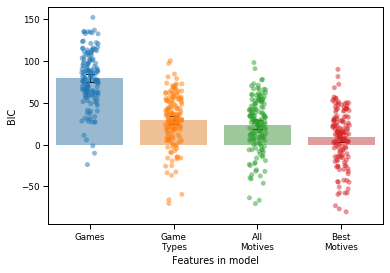

In [68]:
sns.set_context('paper')
fig,ax = plt.subplots(1,1,figsize = [6,4])
bar_order = ['Games', 'Game Types', 'All Motives', 'Best Motives']
xticklabels = ['\n'.join(a.split(' ')) for a in bar_order]

sns.barplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order, errcolor = 'k', capsize = .1, errwidth = 1)
sns.stripplot(data = all_model_fits_cleaned, x = 'model_descr', y = 'BIC', ax = ax, alpha = .5,
            order = bar_order)
# FigureTools.add_sig_markers(ax,relationships=[[2,3,0],[1,2,0]], distScale=.5, ystart = 30)
ax.set(ylabel = 'BIC', xlabel = 'Features in model',
      xticklabels = xticklabels);
# plt.savefig('/Users/jeroen/Desktop/modelcomp.pdf',transparent=True, bbox_inches = 'tight')

##### Stats

In [69]:
def compare_models(name1,name2, out_var = 'BIC', plot_fig = True):
    testdat = all_model_fits_cleaned.query('model_descr == @name1 or model_descr == @name2')
    if plot_fig:
        fig,ax = plt.subplots(1,2,figsize=[10,3])
        sns.barplot(data = testdat, x = 'model_descr', y = out_var, ax = ax[0], order = [name1,name2], alpha = .5)
        sns.swarmplot(data = testdat, x = 'model_descr', y = out_var, ax = ax[0], order = [name1,name2], alpha = .5)
    testdat = testdat.pivot(index = 'sub_ID', columns = 'model_descr', values = out_var).dropna()
    diffs = testdat[name1] - testdat[name2]
    if plot_fig:
        ax[1].hist(diffs)
        ax[1].set(xlabel = '%s - %s'%(name1,name2))
    if scipy.stats.normaltest(diffs)[1] < 0.05:
        stats = scipy.stats.wilcoxon(testdat[name1], testdat[name2])
        test_type = 'nonparametric'
    else:
        stats = scipy.stats.ttest_rel(testdat[name1], testdat[name2])
        test_type = 'parametric'
    coh_d = (np.mean(diffs))/np.std(diffs)
    print('mean delta = %.2f +- %.2f, %i wins %i losses, %s stat = %.4f, p = %.4f, d = %.2f'%(
            np.mean(diffs), np.std(diffs), sum(diffs<0), sum(diffs>0), test_type, stats[0], stats[1], coh_d))
    return stats, diffs

In [70]:
# Compare on BIC
var = 'BIC'
tmp = bar_order
tmp2 = dict(zip(range(len(tmp)),tmp))
for i,name1 in tmp2.items():
    for j,name2 in tmp2.items():
        if j > i:
            print('%s minus %s: '%(name1,name2))
            stats,diffs = compare_models(name1,name2, out_var = var, plot_fig=False)
            print('')

Games minus Game Types: 
mean delta = 49.46 +- 18.99, 2 wins 147 losses, nonparametric stat = 10.0000, p = 0.0000, d = 2.60

Games minus All Motives: 
mean delta = 55.41 +- 25.15, 2 wins 147 losses, nonparametric stat = 7.0000, p = 0.0000, d = 2.20

Games minus Best Motives: 
mean delta = 70.29 +- 27.52, 2 wins 147 losses, nonparametric stat = 3.0000, p = 0.0000, d = 2.55

Game Types minus All Motives: 
mean delta = 5.95 +- 10.23, 36 wins 113 losses, nonparametric stat = 1641.0000, p = 0.0000, d = 0.58

Game Types minus Best Motives: 
mean delta = 20.83 +- 13.43, 5 wins 144 losses, nonparametric stat = 73.0000, p = 0.0000, d = 1.55

All Motives minus Best Motives: 
mean delta = 14.88 +- 10.49, 0 wins 149 losses, nonparametric stat = 0.0000, p = 0.0000, d = 1.42



In [56]:
# model_list = bar_order
# for name1 in model_list:
#     for name2 in model_list:
#         if name1 is not name2:
#             print('%s minus %s: '%(name1,name2))
#             stats,diffs = compare_models(name1,name2, plot_fig=False)
#             print('')

In [71]:
tmp = ['All Motives','Best Motives','Game Types','Coop-Greed']
tmp2 = dict(zip(range(len(tmp)),tmp))
var = 'SSE'
for i,name1 in tmp2.items():
    for j,name2 in tmp2.items():
        if j > i:
            print('%s minus %s: '%(name1,name2))
            stats,diffs = compare_models(name1,name2, out_var = var, plot_fig=False)
            print('')

All Motives minus Best Motives: 
mean delta = 0.33 +- 0.63, 49 wins 100 losses, nonparametric stat = 2343.0000, p = 0.0000, d = 0.53

All Motives minus Game Types: 
mean delta = -0.07 +- 0.52, 76 wins 73 losses, nonparametric stat = 4994.0000, p = 0.2607, d = -0.14

All Motives minus Coop-Greed: 
mean delta = -0.42 +- 1.56, 81 wins 68 losses, nonparametric stat = 4680.5000, p = 0.0856, d = -0.27

Best Motives minus Game Types: 
mean delta = -0.41 +- 0.79, 105 wins 44 losses, nonparametric stat = 2407.0000, p = 0.0000, d = -0.51

Best Motives minus Coop-Greed: 
mean delta = -0.75 +- 1.39, 71 wins 33 losses, nonparametric stat = 771.0000, p = 0.0000, d = -0.54

Game Types minus Coop-Greed: 
mean delta = -0.35 +- 1.37, 84 wins 65 losses, nonparametric stat = 4451.0000, p = 0.0313, d = -0.25

